In [1]:
import numpy as np
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime
from darts.dataprocessing.transformers import Scaler

from darts.models import (
    AutoARIMA,
    Prophet,
    RNNModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
)

from tqdm import tqdm
import numpy as np

from darts.metrics import smape
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.sample(10)
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

In [3]:
store = pd.read_csv('../input/rossmann-store-sales/store.csv')

In [6]:
def get_sample(num):
    sample = df[df.Store == num]
    series = TimeSeries.from_dataframe(sample, 'Date', 'Sales')

    train, test = series.split_before(pd.Timestamp("20150601"))

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    test_transformed = transformer.transform(test)

    series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
    series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
    series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
    series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
    series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
    series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
    series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
    series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

    customers_transformed = transformer.transform(series_customers)

    covariates = series_customers.stack(series_open)
    covariates = covariates.stack(series_promo)
    covariates = covariates.stack(series_school)
    covariates = covariates.stack(series_weekday)
    covariates = covariates.stack(series_holiday_a)
    covariates = covariates.stack(series_holiday_b)
    covariates = covariates.stack(series_holiday_c)

    train_covariates, test_covariates = covariates.split_before(pd.Timestamp("20150601"))

    return train_transformed, test_transformed, covariates

In [7]:
train, test, covariates = get_sample(10)

In [8]:
cdf = df.groupby('Store').count().reset_index()[['Store', 'Date']]
store_merged = pd.merge(store, cdf, left_on='Store', right_on='Store')
store_merged = store_merged[store_merged.Date == 942]

In [9]:
def rmspe(actual, pred):
    return np.sqrt(np.mean( ((actual - pred) / actual)**2)) 

def smape(actual, pred):
    return np.mean(np.abs(pred - actual) / ((np.abs(actual) + np.abs(pred))/2)) * 100

def evaluate_model(model, train, test):
    model.fit(train)
    pred = model.predict(len(test))
    test = test.pd_dataframe()
    pred = pred.pd_dataframe()

    test.columns = ['Actual']
    pred.columns = ['Pred']

    df = pd.concat([test, pred], axis=1)
    df = df[df.Actual > 0]
    return smape(df.Actual.values, df.Pred.values), rmspe(df.Actual.values, df.Pred.values)

In [46]:
train_transformed, test_transformed, covariates = get_sample(10)
auto_arima = AutoARIMA()
rmspe_score, smape_score = evaluate_model(auto_arima, train_transformed, test_transformed )
rmspe_score, smape_score

(40.947699888911366, 0.3491594985738361)

In [11]:
store_num_list = pd.read_csv('../input/store_list.csv').Store.values
store_num_list

array([  10,   62,  110,  163,  300,  333,  388,  392,  448,  467,  486,
        489,  524,  549,  566,  632,  749,  765,  811,  826,  872,  880,
        883,  896,  913,  954,  956,  966, 1022, 1108,  259,  335,  353,
        423,  494,  562,  676,  682,  733,  769,   70,  130,  131,  208,
        321,  349,  382,  398,  442,  444,  474,  482,  499,  554,  595,
        654,  666,  678,  708,  747,  787,  854,  857,  860,  861,  968,
        978,  996, 1006, 1055,   31,   56,   75,   80,   94,  154,  261,
        291,  350,  356,  372,  424,  493,  521,  525,  578,  585,  601,
        605,  723,  740,  803,  850,  865,  940,  960, 1010, 1046, 1089,
       1101], dtype=int64)

## 1. ARIMA

### 1.1 Naive ARIMA Model

In [13]:
smape_list = []
rmspe_list = []

from darts.metrics.metrics import mape
for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    auto_arima = AutoARIMA()
    smape_score, rmspe_score = evaluate_model(auto_arima, train_transformed, test_transformed )
    rmspe_list.append(rmspe_score)
    smape_list.append(smape_score)


100%|██████████| 100/100 [17:14<00:00, 10.34s/it]


25.893527533760267 6.461667138932717 55.210198889272874 9.749707784199694


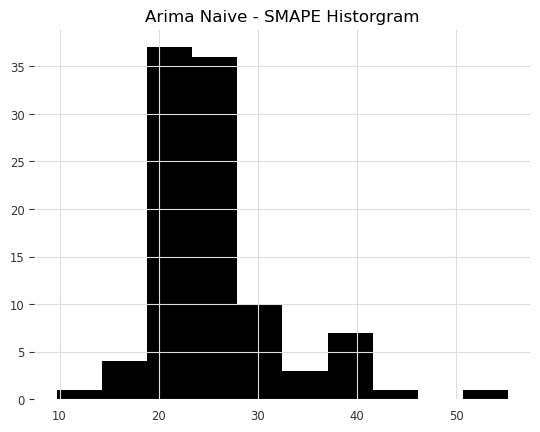

In [14]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)
plt.title('Arima Naive - SMAPE Historgram')
plt.show()

0.28728813433207867 0.10058091622477572 0.8907941004479036 0.11872394062445944


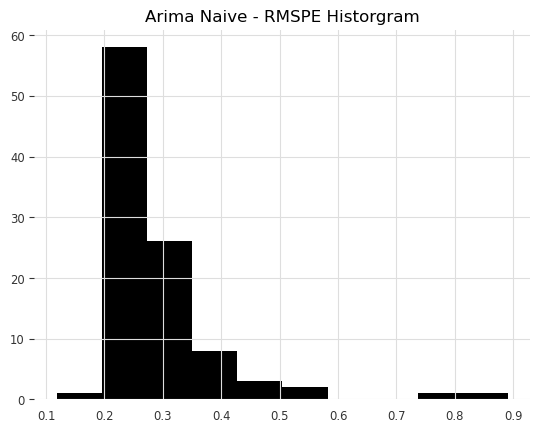

In [15]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)
plt.title('Arima Naive - RMSPE Historgram')
plt.show()

In [16]:
res1 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)

### 1.2 Covrariate ARIMA Model

In [17]:
def evaluate_covariates_model(model, train, test, covariates):
    model.fit(train, future_covariates=covariates)
    pred = model.predict(len(test), future_covariates=covariates)
    test = test.pd_dataframe()
    pred = pred.pd_dataframe()

    test.columns = ['Actual']
    pred.columns = ['Pred']

    df = pd.concat([test, pred], axis=1)
    df = df[df.Actual > 0]
    return smape(df.Actual.values, df.Pred.values), rmspe(df.Actual.values, df.Pred.values)


In [18]:
smape_list = []
rmspe_list = []

for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    auto_arima = AutoARIMA()
    mape_score, rmse_score = evaluate_covariates_model(auto_arima, train_transformed, test_transformed, covariates )
    smape_list.append(mape_score)
    rmspe_list.append(rmse_score)

100%|██████████| 100/100 [36:39<00:00, 21.99s/it]


6.151082270280114 2.031409808043103 13.483208444250586 3.1306060359982832


(array([ 7., 33., 23., 16.,  9.,  4.,  2.,  2.,  2.,  2.]),
 array([ 3.13060604,  4.16586628,  5.20112652,  6.23638676,  7.271647  ,
         8.30690724,  9.34216748, 10.37742772, 11.41268796, 12.4479482 ,
        13.48320844]),
 <BarContainer object of 10 artists>)

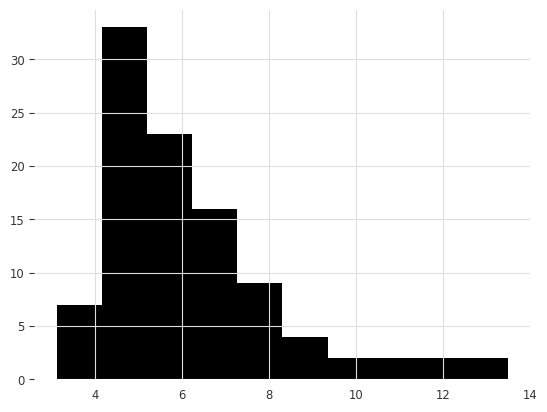

In [19]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)

0.07521285164485227 0.02552035248355856 0.16102376919725797 0.03973206278729316


(array([ 9., 34., 22., 14.,  9.,  3.,  2.,  2.,  1.,  4.]),
 array([0.03973206, 0.05186123, 0.0639904 , 0.07611957, 0.08824875,
        0.10037792, 0.11250709, 0.12463626, 0.13676543, 0.1488946 ,
        0.16102377]),
 <BarContainer object of 10 artists>)

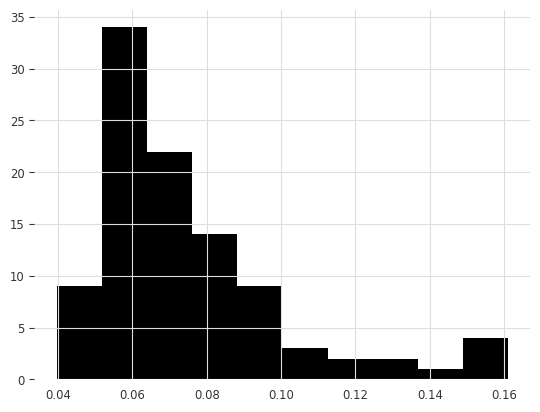

In [20]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)

In [21]:
res2 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)
res2.to_csv('ariama2.csv')

In [22]:
res_naive = res1
res_naive['Store'] = store_num_list
res_cov = res2
res_cov['Store'] = store_num_list
result = pd.merge(res_naive, res_cov, left_on='Store', right_on='Store')
result = result.set_index('Store')
result = pd.merge(result, store[['Store','StoreType']], left_on='Store', right_on='Store')
result.to_csv('../output/arima_result.csv')
result.head()

,Store,rmspe_x,smape_x,rmspe_y,smape_y,StoreType
0,10,0.349159,40.947700,0.068944,5.738727,a
1,62,0.336015,29.373256,0.058400,4.740602,a
2,110,0.267641,26.516061,0.081811,6.305906,a
3,163,0.217318,19.678062,0.061239,5.065973,a
4,300,0.230775,22.075986,0.056746,4.735623,a


Text(0.5, 1.0, 'AutoARIMA')

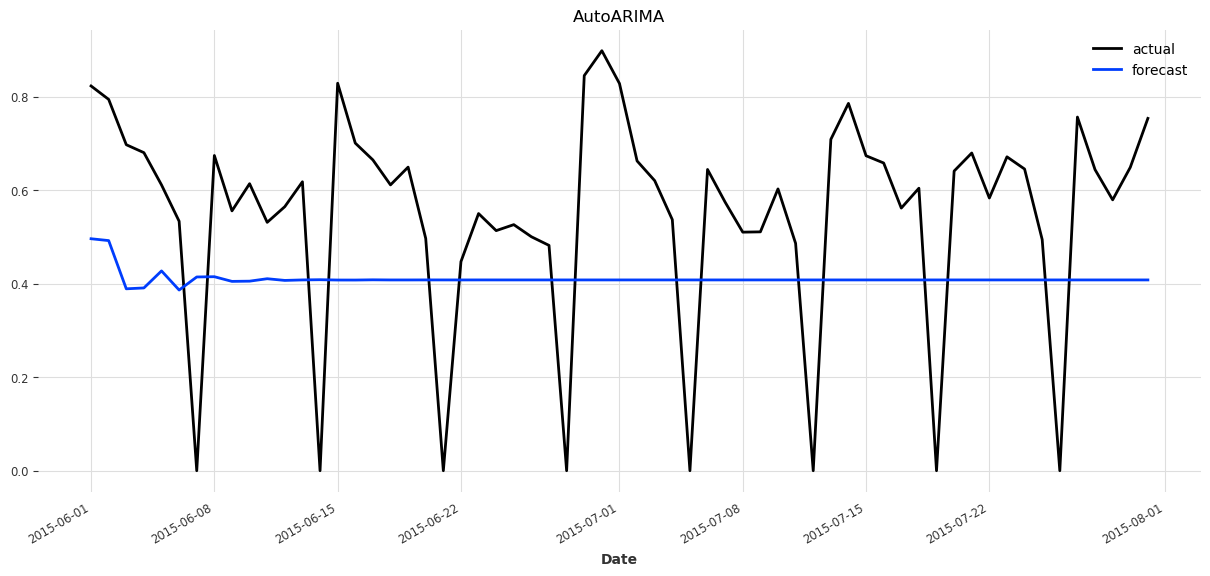

In [47]:
arima = AutoARIMA()
arima.fit(train_transformed)
pred_demand_covs = arima.predict(len(test_transformed))

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('AutoARIMA')

ari

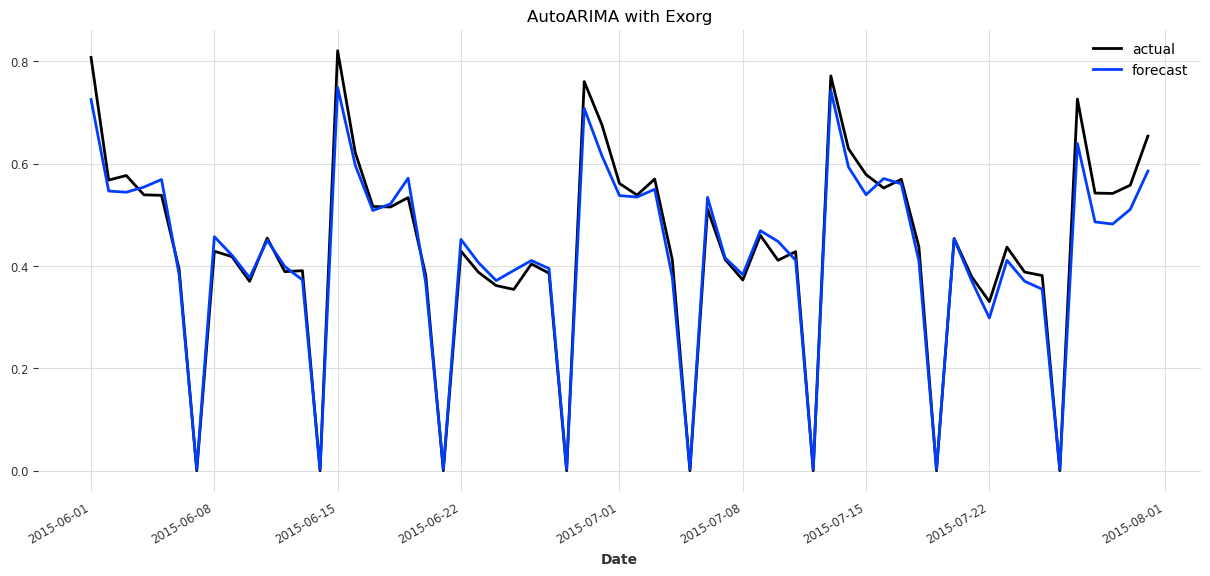

In [45]:
arima = AutoARIMA()
arima.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = arima.predict(len(test_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('AutoARIMA with Exorg')
plt.show()

In [43]:
res1.mean()

rmspe      0.287288
smape     25.893528
Store    585.390000
dtype: float64

In [44]:
res2.mean()

rmspe      0.075213
smape      6.151082
Store    585.390000
dtype: float64